<a href="https://colab.research.google.com/github/varshithbollam/Assignment-Trader_Performance_vs_Market_Sentiment/blob/main/Assignment_Trader_Performance_vs_Market_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trader Performance vs Market Sentiment Analysis

**Submitted by:** Varshith Bollam  
**Email:** varshithbollam12@gmail.com  
**Phone:** +91-7382480412  

### Datasets
- [Historical Data](https://drive.google.com/file/d/1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs/view?usp=sharing)  
- [Fear & Greed Index](https://drive.google.com/file/d/1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf/view?usp=sharing)

#  Import Libraries

In [ ]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from google.colab import drive





#  Load Datasets

In [ ]:
fg_url = "https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"
trades_url = "https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"

fg = pd.read_csv(fg_url)
trades = pd.read_csv(trades_url)

print("Done loading — rows:", fg.shape, trades.shape)



Done loading — rows: (2644, 4) (211224, 16)


# Clean Fear/Greed Dataset

In [ ]:

fg = fg.rename(columns={"classification": "sentiment"})
fg["date"] = pd.to_datetime(fg["date"], errors="coerce")
fg = fg[["date", "sentiment"]]




#  Clean Trades Dataset

In [ ]:


# Normalize column names (lowercase, replace spaces with underscores)
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")

# Standardize symbol column
if "symbol" not in trades.columns:
    if "coin" in trades.columns:
        trades = trades.rename(columns={"coin": "symbol"})
    elif "trade_symbol" in trades.columns:
        trades = trades.rename(columns={"trade_symbol": "symbol"})

# Handle leverage (not present, so set NaN)
if "leverage" in trades.columns:
    trades["leverage"] = pd.to_numeric(trades["leverage"], errors="coerce")
else:
    trades["leverage"] = np.nan

# Normalize size column
if "size" in trades.columns:
    trades["size"] = pd.to_numeric(trades["size"], errors="coerce")
elif "size_usd" in trades.columns:
    trades = trades.rename(columns={"size_usd": "size"})
    trades["size"] = pd.to_numeric(trades["size"], errors="coerce")
elif "size_tokens" in trades.columns:
    trades = trades.rename(columns={"size_tokens": "size"})
    trades["size"] = pd.to_numeric(trades["size"], errors="coerce")

# Clean closed PnL
if "closed_pnl" in trades.columns:
    trades["closed_pnl"] = pd.to_numeric(trades["closed_pnl"], errors="coerce")
else:
    trades["closed_pnl"] = np.nan

# Parse Timestamp IST (format: DD-MM-YYYY HH:MM)
if "timestamp_ist" in trades.columns:
    trades["date"] = pd.to_datetime(trades["timestamp_ist"], format="%d-%m-%Y %H:%M", errors="coerce").dt.date
elif "timestamp" in trades.columns:
    trades["date"] = pd.to_datetime(trades["timestamp"], errors="coerce").dt.date
else:
    raise ValueError("No valid timestamp column found in trades dataset.")

trades["date"] = pd.to_datetime(trades["date"], errors="coerce")





#  Merge Trader Data with Sentiment

In [ ]:

merged = pd.merge(trades, fg, on="date", how="left")
print("Merged dataset shape:", merged.shape)



Merged dataset shape: (211224, 19)


# Visualization 1: Average Trade Size by Sentiment





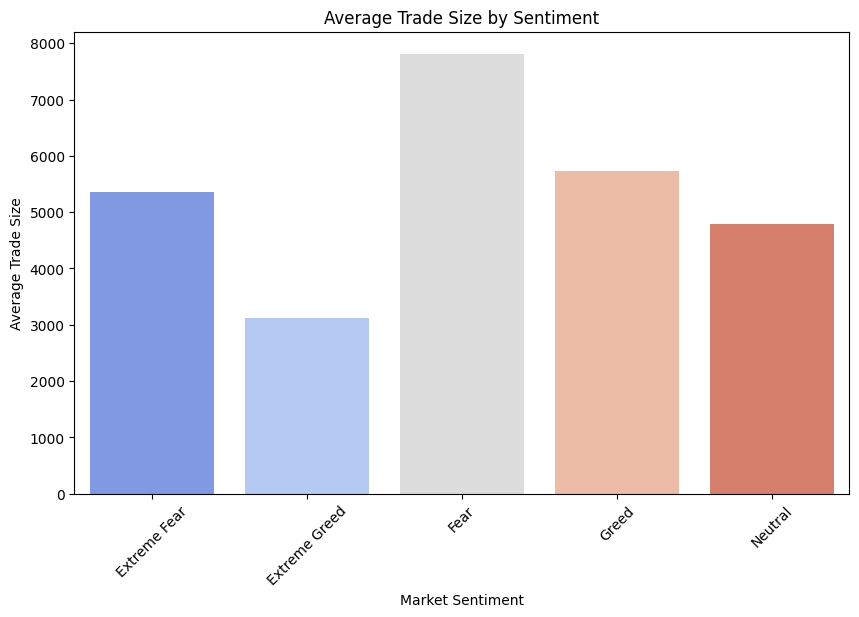

In [ ]:

plt.figure(figsize=(10,6))
avg_size = merged.groupby("sentiment")["size"].mean().reset_index()

sns.barplot(data=avg_size, x="sentiment", y="size", palette="coolwarm")
plt.title("Average Trade Size by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Trade Size")
plt.xticks(rotation=45)
plt.show()





# Visualization 2: Win Rate by Sentiment

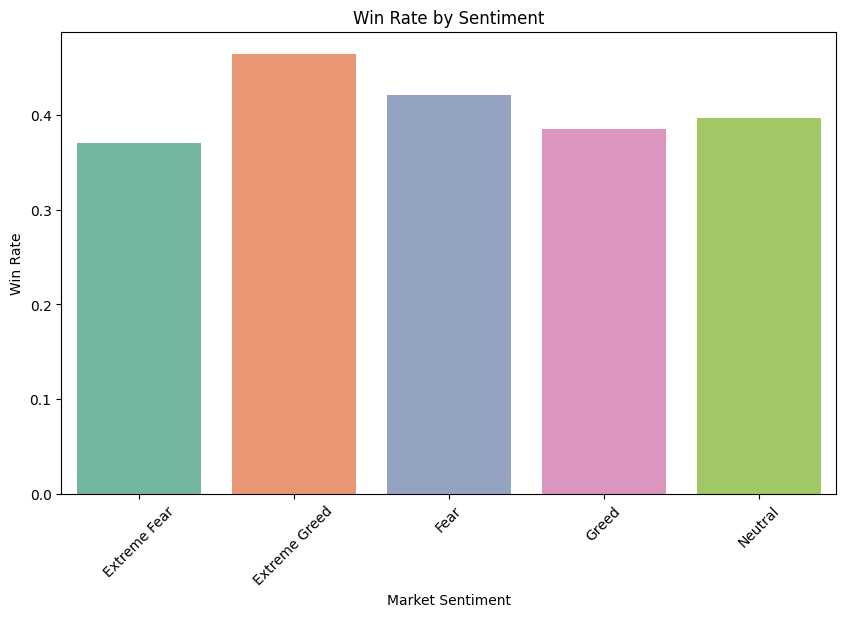

In [ ]:

win_rate = merged.groupby("sentiment").apply(
    lambda df: (df["closed_pnl"] > 0).mean()
).reset_index(name="win_rate")

plt.figure(figsize=(10,6))
sns.barplot(data=win_rate, x="sentiment", y="win_rate", palette="Set2")
plt.title("Win Rate by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Win Rate")
plt.xticks(rotation=45)
plt.show()




# Visualization 3: Cumulative PnL Over Time with Sentiment Overlay

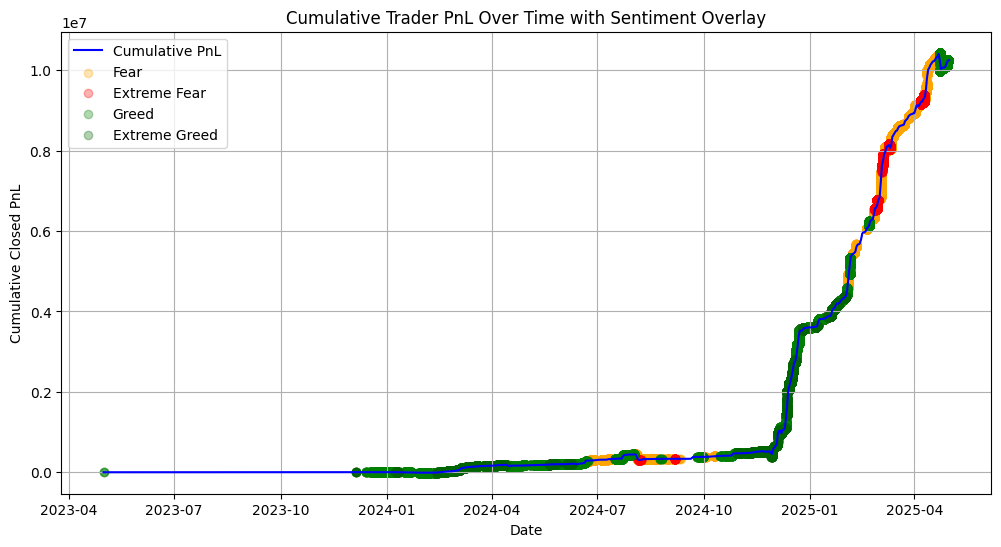

In [ ]:

merged = merged.sort_values("date")
merged["cumulative_pnl"] = merged["closed_pnl"].cumsum()

plt.figure(figsize=(12,6))
sns.lineplot(data=merged, x="date", y="cumulative_pnl", color="blue", label="Cumulative PnL")

# Overlay sentiment markers
sentiment_map = {
    "Fear": "orange",
    "Extreme Fear": "red",
    "Greed": "green",
    "Extreme Greed": "darkgreen"
}

for sentiment, color in sentiment_map.items():
    subset = merged[merged["sentiment"] == sentiment]
    plt.scatter(subset["date"], subset["cumulative_pnl"], alpha=0.3, label=sentiment, color=color)

plt.title("Cumulative Trader PnL Over Time with Sentiment Overlay")
plt.xlabel("Date")
plt.ylabel("Cumulative Closed PnL")
plt.legend()
plt.grid(True)
plt.show()

# Visualization 4: PnL Distribution by Sentiment

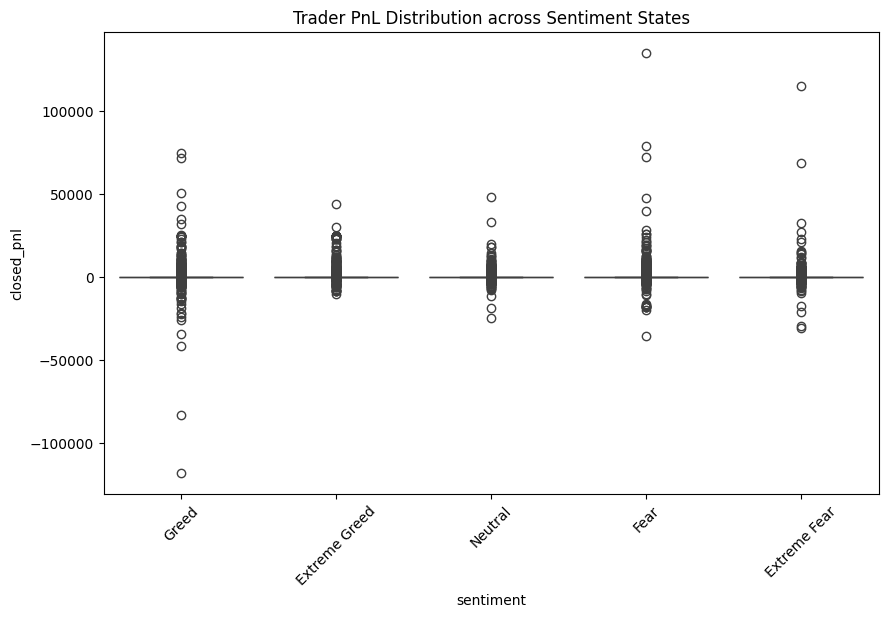

In [ ]:

plt.figure(figsize=(10,6))
sns.boxplot(data=merged, x="sentiment", y="closed_pnl")
plt.title("Trader PnL Distribution across Sentiment States")
plt.xticks(rotation=45)
plt.show()



# Visualization 5: Win Rate by Sentiment

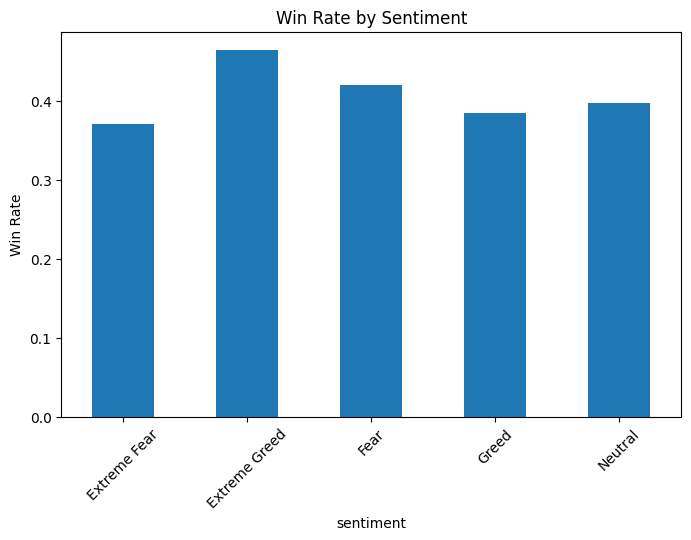

In [ ]:

win_rate = merged.groupby("sentiment").apply(
    lambda df: (df["closed_pnl"] > 0).mean()
)
win_rate.plot(kind="bar", figsize=(8,5), ylabel="Win Rate", title="Win Rate by Sentiment")
plt.xticks(rotation=45)
plt.show()



#  Visualization 6: Trade Volume by Sentiment

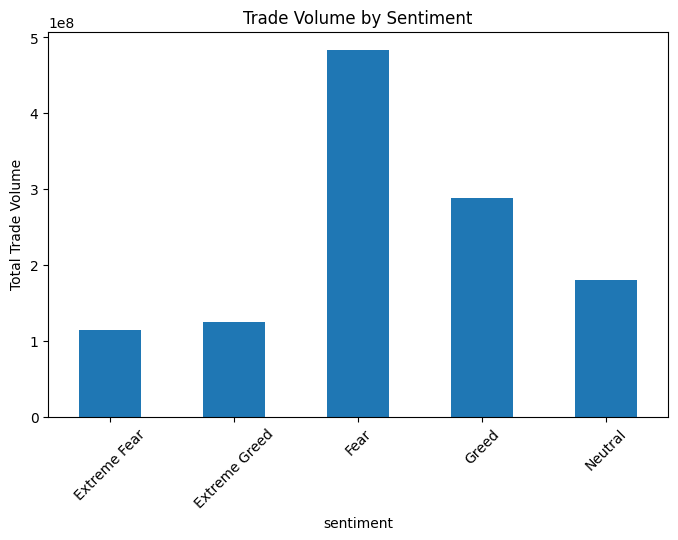

In [ ]:

volume = merged.groupby("sentiment")["size"].sum()
volume.plot(kind="bar", figsize=(8,5), ylabel="Total Trade Volume", title="Trade Volume by Sentiment")
plt.xticks(rotation=45)
plt.show()



#  Visualization 7: PnL Over Time with Sentiment Overlay

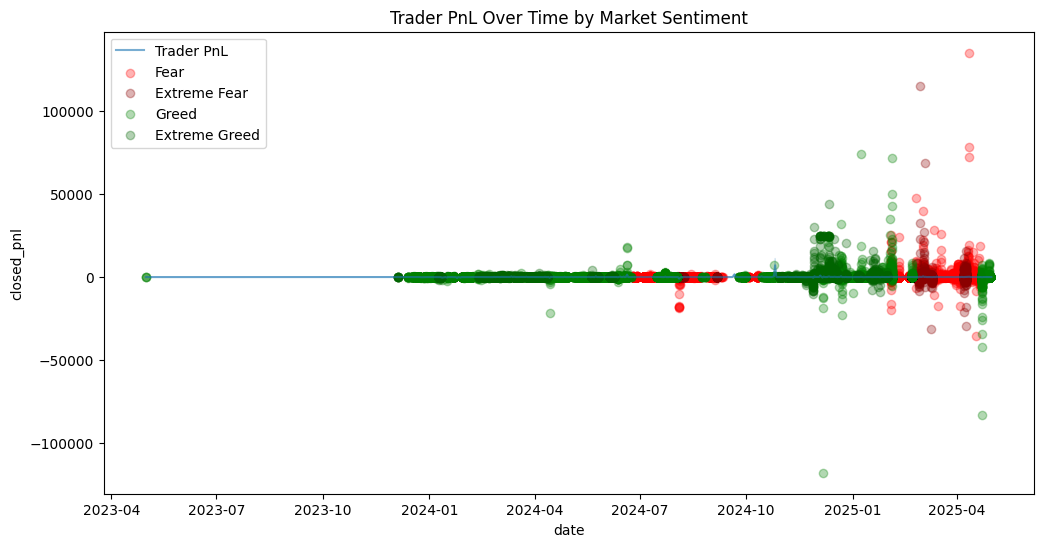

In [ ]:

plt.figure(figsize=(12,6))
sns.lineplot(data=merged, x="date", y="closed_pnl", label="Trader PnL", alpha=0.6)

sentiment_map = {
    "Fear": "red",
    "Extreme Fear": "darkred",
    "Greed": "green",
    "Extreme Greed": "darkgreen"
}

for sentiment, color in sentiment_map.items():
    dates = merged[merged["sentiment"] == sentiment]["date"]
    plt.scatter(dates, merged.loc[merged["sentiment"] == sentiment, "closed_pnl"],
                color=color, alpha=0.3, label=sentiment)

plt.title("Trader PnL Over Time by Market Sentiment")
plt.legend()
plt.show()



#  Visualization 8: Correlation Heatmap

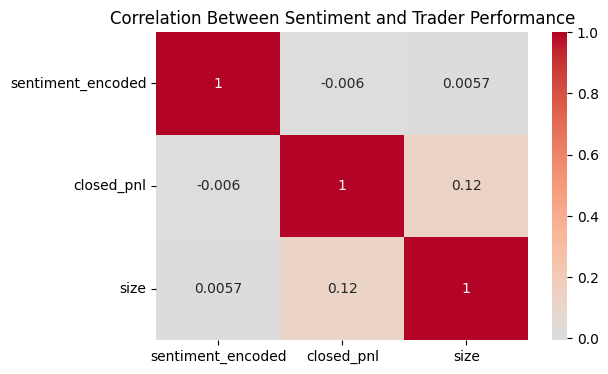

In [ ]:

df_corr = merged.copy()
df_corr["sentiment_encoded"] = LabelEncoder().fit_transform(df_corr["sentiment"].astype(str))

corr = df_corr[["sentiment_encoded", "closed_pnl", "size"]].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Between Sentiment and Trader Performance")
plt.show()